In [1]:
import jax, numpyro
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

from tensorflow.keras.models import load_model
from jax.experimental import jax2tf
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.distributions.transforms import AffineTransform
from numpyro.distributions import (
    Normal, Beta, ImproperUniform, Uniform, Pareto, TruncatedNormal, Categorical, MixtureSameFamily,
    OrderedLogistic, LogNormal, TransformedDistribution
)
from numpyro.distributions.constraints import interval, unit_interval
from corner import corner

numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)
# numpyro.set_platform("gpu")

# numpyro.enable_x64()
rng = random.PRNGKey(0)

In [2]:
path = "/mnt/data-storage/stellar-emulator/train/20230628-155230/best_model.tf"
tf_emulator = load_model(path)
# emulator = jax2tf.call_tf(tf_emulator)  # Too slow, due to normalization layer?

In [3]:
weights = tf_emulator.get_weights()
offset = np.array(tf_emulator.layers[-1].offset)
scale = np.array(tf_emulator.layers[-1].scale)

@jax.jit
def emulator(x):
    x -= weights[0]
    x /= weights[1]**0.5
    for w, b in zip(weights[3:-2:2], weights[4:-1:2]):
        x = jax.nn.elu(jnp.matmul(x, w) + b)
    x = jnp.matmul(x, weights[-2]) + weights[-1]
    return offset + scale * x

In [4]:
log_zx_sun = np.log10(0.0181)
log_teff_sun = np.log10(5772)

In [5]:
from numpyro.distributions.util import promote_shapes
from numpyro.distributions import Distribution, constraints
from jax import lax

In [6]:
class Salpeter(Distribution):
    arg_constraints = {
        "alpha": constraints.positive,
        "low": constraints.positive,
        "high": constraints.positive
    }
    reparametrized_params = ["alpha", "low", "high"]

    def __init__(self, alpha, *, low=0.1, high=float("inf"), validate_args=None):
        batch_shape = lax.broadcast_shapes(
            jnp.shape(alpha),
            jnp.shape(low),
            jnp.shape(high),
        )
        self.alpha, self.low, self.high = promote_shapes(alpha, low, high)
        self.beta = 1 - self.alpha
        super().__init__(batch_shape, validate_args=validate_args)

    @constraints.dependent_property
    def support(self):
        return constraints.interval(self.low, self.high)

    @property
    def _norm(self):
        return (self.high**self.beta - self.low**self.beta) / self.beta

    def log_prob(self, value):
        log_m = jnp.log(self._norm)
        log_p = - self.alpha * jnp.log(value)
        return jnp.where((value <= self.high) & (value > self.low), log_p - log_m, -jnp.inf)

    def cdf(self, value):
        return (value**self.beta - self.low**self.beta) / self.beta / self._norm
    
    def icdf(self, u):
        return (self.beta * self._norm * u + self.low**self.beta)**(1/self.beta)
    
    def sample(self, key, sample_shape=()):
        shape = sample_shape + self.batch_shape
        minval = jnp.finfo(jnp.result_type(float)).tiny
        u = random.uniform(key, shape, minval=minval)
        return self.icdf(u)

In [7]:
def ScaledBeta(conc1, conc2, low=0.0, high=1.0, validate_args=None):
#     return TransformedDistribution(
#         Beta(conc1, conc2),
#         AffineTransform(low, (high - low), domain=unit_interval),
#         validate_args=validate_args
#     )
    return Uniform(low, high, validate_args=validate_args)

In [8]:
def log_luminosity(log_teff, log_radius):
    return 2 * log_radius + 4 * (log_teff - log_teff_sun)

def hydrogen(log_z, y):
    return 1 - y - 10**log_z

def metallicity(log_z, y):    
    return log_z - jnp.log10(hydrogen(log_z, y)) - log_zx_sun

def model(num_stars, lum=None, teff=None, mh=None, dnu=None,
          sigma_lum=0.05, sigma_teff=50.0, sigma_mh=0.05, sigma_dnu=0.5):

    with numpyro.plate("star", num_stars):
        eep = numpyro.sample("EEP", ScaledBeta(1.2, 1.2, 0.1, 3.9))
        mass = numpyro.sample("mass", Salpeter(2.35, low=0.75, high=2.25))
        log_z = numpyro.sample("log_Z", ScaledBeta(1.2, 1.2, -2.7, -1.4))
        z = numpyro.deterministic("Z", 10**log_z)
        y = numpyro.sample("Y", ScaledBeta(1.2, 1.2, 0.23, 0.31))
        
        a_mlt = numpyro.sample("a_MLT", ScaledBeta(1.2, 1.2, 1.4, 2.6))
        
        xx = jnp.stack([eep, mass, y, log_z, a_mlt], axis=-1)
        yy = emulator(xx)

        log_lum = log_luminosity(yy[:, 1], yy[:, 2])
        _lum = 10**log_lum
        _teff = 10**yy[:, 1]
        _mh = metallicity(log_z, y)
        _dnu = 10**yy[:, -1]
        
        numpyro.sample("lum", Normal(_lum, sigma_lum), obs=lum)
        numpyro.sample("Teff", Normal(_teff, sigma_teff), obs=teff)
        numpyro.sample("[M/H]", Normal(_mh, sigma_mh), obs=mh)
        numpyro.sample("Dnu", Normal(_dnu, sigma_dnu), obs=dnu)

    #         numpyro.deterministic("[M/H]", _mh)
        log_age = numpyro.deterministic("log_age", yy[:, 0])
        age = numpyro.deterministic("age", 10**log_age)
        rad = numpyro.deterministic("rad", 10**yy[:, 2])

def hierarchical_model(num_stars, lum=None, teff=None, mh=None, dnu=None,
          sigma_lum=0.05, sigma_teff=100.0, sigma_mh=0.1, sigma_dnu=0.5):

    dydz = numpyro.sample("dYdZ", Normal(1.5, 0.5))
    yp = numpyro.sample("Y_p", Normal(0.24, 0.005))
    sigma_y = numpyro.sample("sigma_Y", LogNormal(jnp.log(0.005), 0.3))
    
    a_mlt = numpyro.sample("a_MLT", ScaledBeta(1.2, 1.2, 1.4, 2.6))

    with numpyro.plate("star", num_stars):
        eep = numpyro.sample("EEP", ScaledBeta(1.2, 1.2, 0.1, 3.9))
        mass = numpyro.sample("mass", Salpeter(2.35, low=0.75, high=2.25))
        log_z = numpyro.sample("log_Z", ScaledBeta(1.2, 1.2, -2.7, -1.4))
        z = numpyro.deterministic("Z", 10**log_z)
        mu_y = yp + dydz * z

#         scaled_y = numpyro.sample("scaled_Y", Normal())
#         y = numpyro.deterministic("Y", mu_y + sigma_y * scaled_y)
#         y = numpyro.sample("Y", Normal(mu_y, sigma_y))
#         y = numpyro.sample("Y", TruncatedNormal(mu_y, sigma_y, low=0.22, high=0.32))
        low = (0.22 - mu_y) / sigma_y
        high = (0.32 - mu_y) / sigma_y
        _y = numpyro.sample("Y_decentered", TruncatedNormal(0, 1, low=low, high=high))
        y = numpyro.deterministic("Y", mu_y + sigma_y * _y)
        xx = jnp.stack([eep, mass, y, log_z, a_mlt*jnp.ones(num_stars)], axis=-1)
        yy = emulator(xx)

        log_lum = log_luminosity(yy[:, 1], yy[:, 2])
        _lum = 10**log_lum
        _teff = 10**yy[:, 1]
        _mh = metallicity(log_z, y)  # Some of these are NaN
        _dnu = 10**yy[:, -1]

        numpyro.sample("lum", Normal(_lum, sigma_lum), obs=lum)
        numpyro.sample("Teff", Normal(_teff, sigma_teff), obs=teff)
        numpyro.sample("[M/H]", Normal(_mh, sigma_mh), obs=mh)
        numpyro.sample("Dnu", Normal(_dnu, sigma_dnu), obs=dnu)
#         numpyro.deterministic("[M/H]", _mh)
        log_age = numpyro.deterministic("log_age", yy[:, 0])
        age = numpyro.deterministic("age", 10**log_age)
        rad = numpyro.deterministic("rad", 10**yy[:, 2])

In [9]:
true_params = {
    "dYdZ": 1.5,
    "Y_p": 0.24,
    "sigma_Y": 0.005,
    "a_MLT": 2.0
}

In [10]:
num_stars = 5

rng, key = random.split(rng)
true_model = numpyro.handlers.substitute(
    hierarchical_model,
    data=true_params,
)
true_predictive = Predictive(true_model, num_samples=1, batch_ndims=0)
true_stars = true_predictive(key, num_stars)

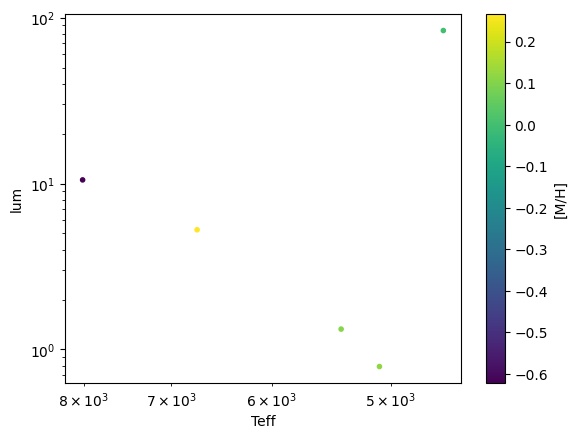

In [11]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "lum"
ckey = "[M/H]"
alpha = 1.0

s = ax.scatter(true_stars[xkey], true_stars[ykey], 
           c=true_stars[ckey], marker=".", alpha=alpha)
ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey);

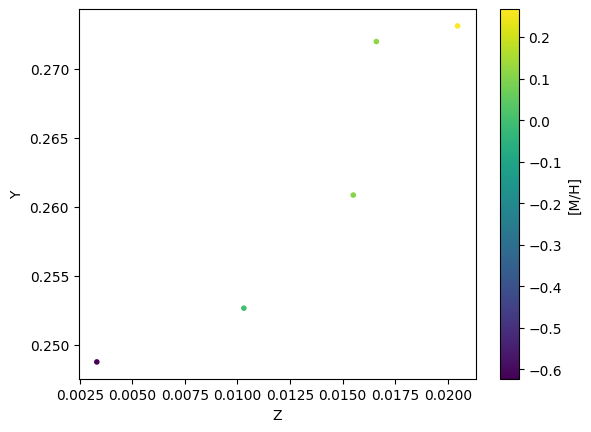

In [12]:
fig, ax = plt.subplots()
xkey = "Z"
ykey = "Y"
ckey = "[M/H]"
alpha = 1.0

s = ax.scatter(true_stars[xkey], true_stars[ykey], 
           c=true_stars[ckey], marker=".", alpha=alpha)

ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey);

In [13]:
rng, key = random.split(rng)
prior_predictive = Predictive(model, num_samples=1000)
prior_samples = prior_predictive(key, num_stars)

In [14]:
coords = {"star": np.arange(num_stars)}
dims = {k: ["star"] for k, v in prior_samples.items() if v.ndim == 2}
data = az.from_numpyro(prior=prior_samples, coords=coords, dims=dims)
data

Inference data with groups:
	> prior

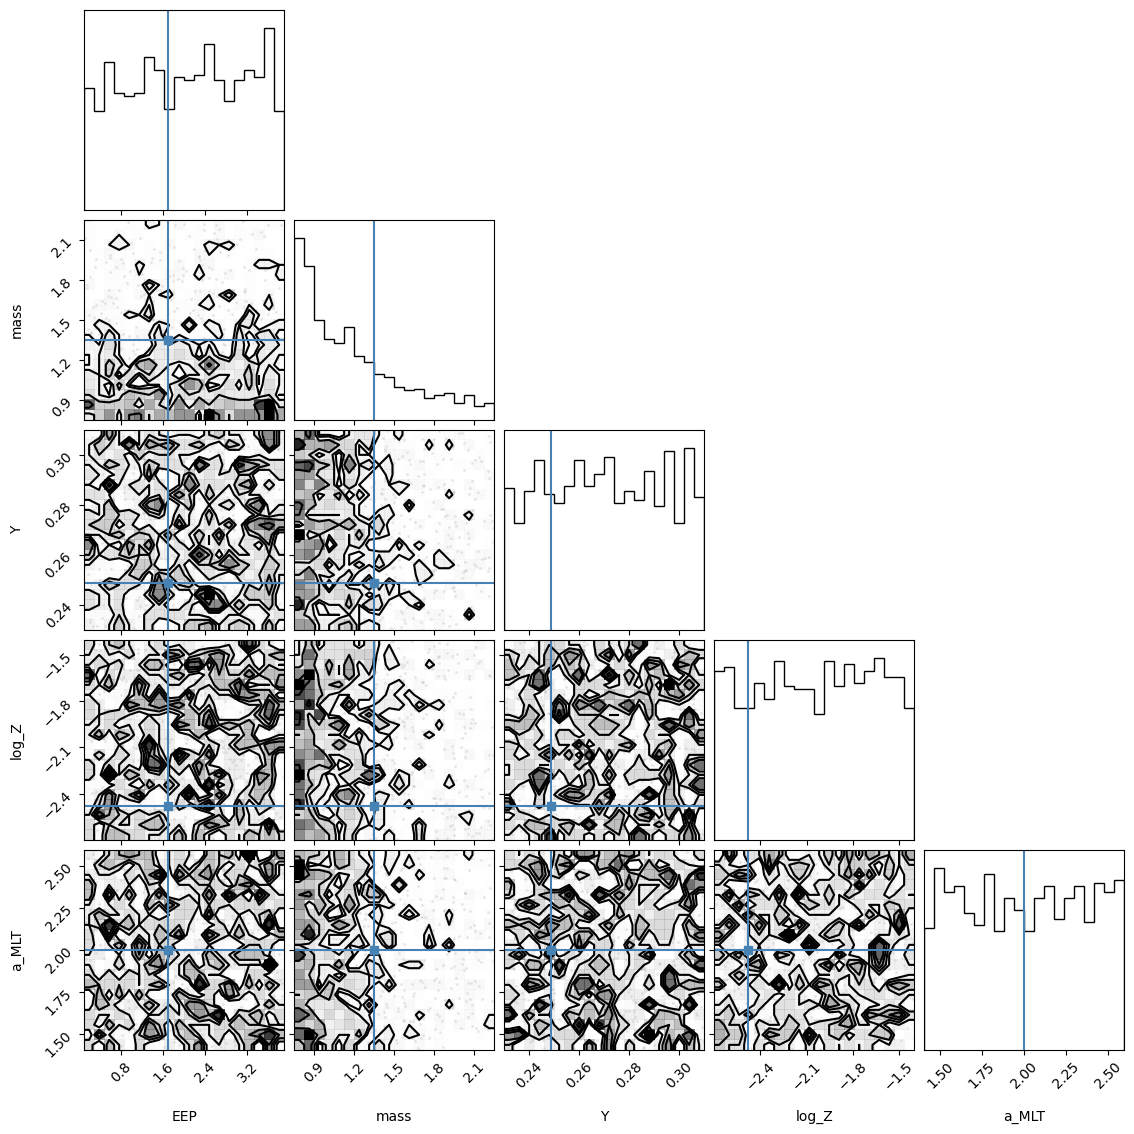

In [15]:
star = 0
var_names = ["EEP", "mass", "Y", "log_Z", "a_MLT"]
truths = {k: true_params[k] if k in true_params else true_stars[k][0, star] for k in var_names}
fig = corner(data, group="prior", var_names=var_names, coords={"star": star}, truths=truths)

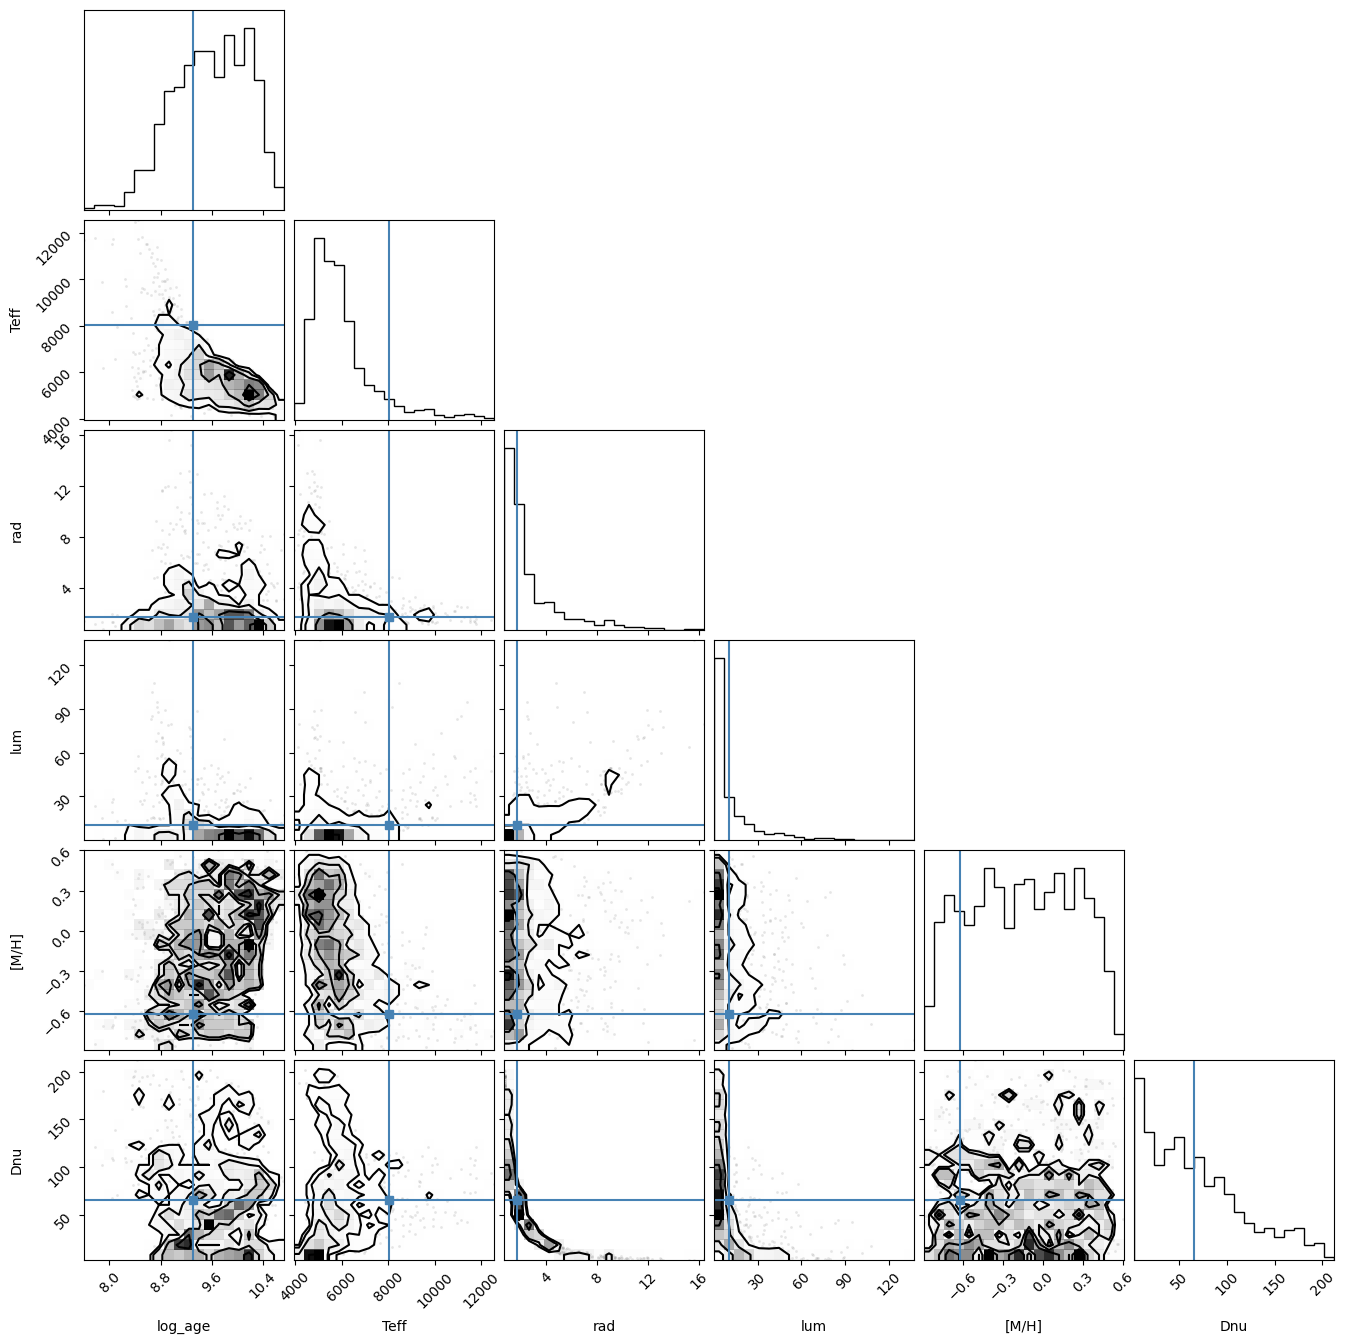

In [17]:
star = 0
var_names = ["log_age", "Teff", "rad", "lum", "[M/H]", "Dnu"]
truths = {k: true_stars[k][0, star] for k in var_names}
fig = corner(data, group="prior", var_names=var_names, coords={"star": star}, truths=truths)

In [18]:
teff = true_stars["Teff"].squeeze()
lum = true_stars["lum"].squeeze()
mh = true_stars["[M/H]"].squeeze()
dnu = true_stars["Dnu"].squeeze()

In [19]:
from numpyro.infer.reparam import LocScaleReparam
from numpyro.infer import (
    init_to_median, init_to_sample, init_to_value, HMC
)

In [20]:
num_warmup, num_samples, num_chains = 2000, 1000, 4
nuts = NUTS(model, init_strategy=init_to_median)
mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

In [21]:
rng, key = random.split(rng)
mcmc.run(key, num_stars, lum=lum, teff=teff, mh=mh)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [22]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    Dnu[0]     65.83      2.58     66.16     61.58     69.58     26.68      1.10
    Dnu[1]     67.62      3.95     65.93     63.54     74.95      2.24      2.96
    Dnu[2]     10.86     10.47      5.49      3.12     29.36      2.00     21.69
    Dnu[3]     84.02      4.39     83.58     77.02     91.41   1357.40      1.00
    Dnu[4]     99.69      7.15     99.16     88.10    110.63   1094.17      1.00
    EEP[0]      1.58      0.22      1.68      1.26      1.85     11.58      1.20
    EEP[1]      1.38      0.46      1.63      0.54      1.72      2.08      5.13
    EEP[2]      2.84      0.75      2.95      1.67      3.80      2.00     31.75
    EEP[3]      2.15      0.30      2.15      1.67      2.65    977.77      1.01
    EEP[4]      1.93      0.22      1.91      1.60      2.32    842.14      1.01
      Y[0]      0.26      0.02      0.26      0.23      0.30    132.74      1.03
      Y[1]      0.30      0

In [37]:
data += az.from_numpyro(mcmc, coords=coords, dims=dims)
data

TypeError: Concatenating overlapping groups is not supported unless `dim` is defined. Valid dimensions are `chain` and `draw`. Alternatively, use extend to combine InferenceData with overlapping groups

In [ ]:
star = 8
az.plot_trace(data, coords={"star": star});

In [25]:
rng, key = random.split(rng)
post_predictive = Predictive(model, posterior_samples=mcmc.get_samples())
post_samples = post_predictive(key, num_stars)

In [26]:
data += az.from_numpyro(posterior_predictive=post_samples, coords=coords, dims=dims)
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

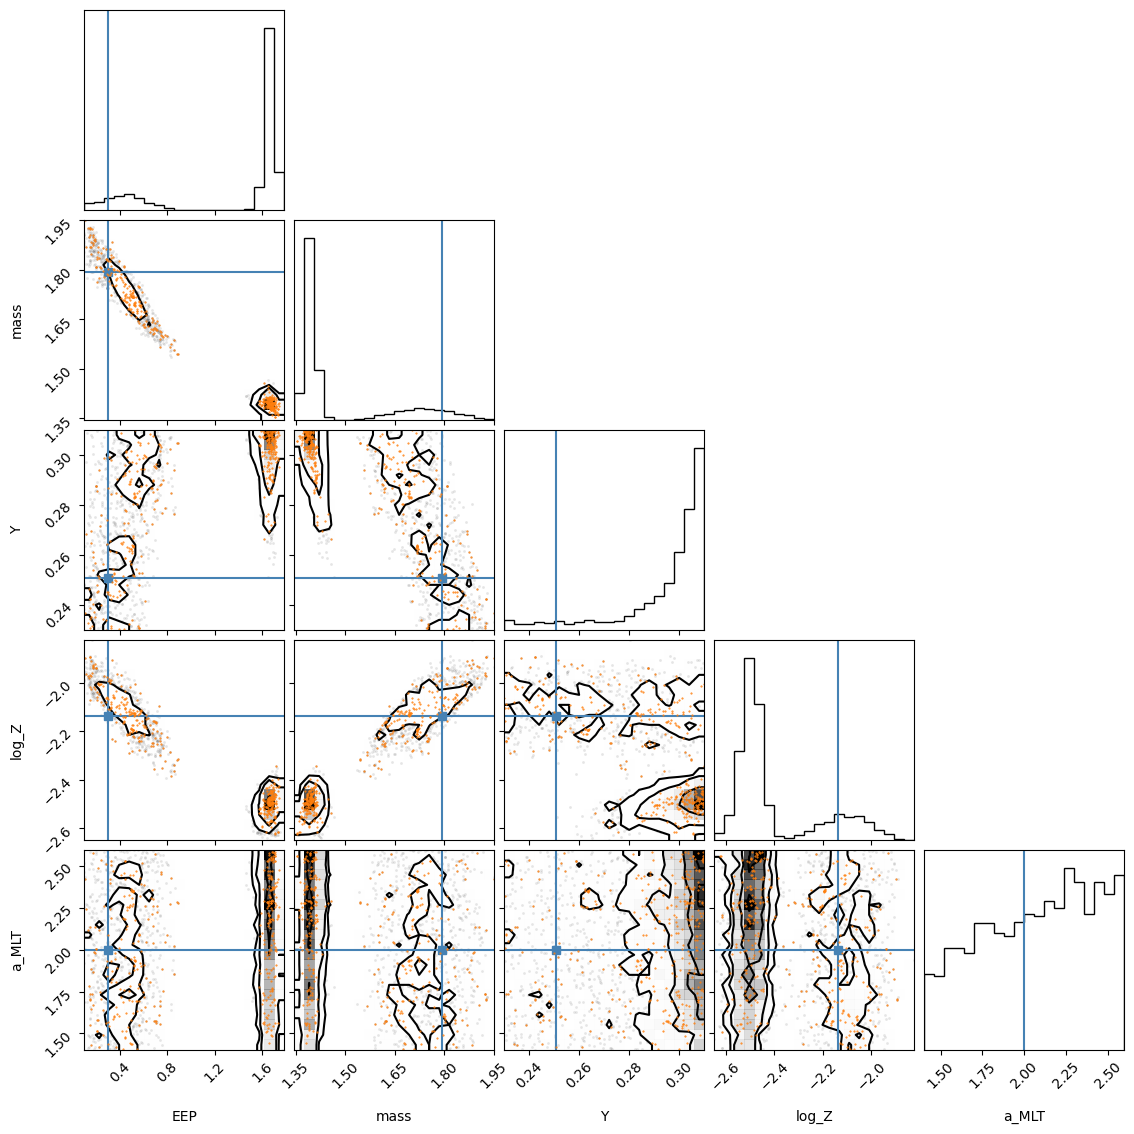

In [31]:
star = 8
var_names = ["EEP", "mass", "Y", "log_Z", "a_MLT"]
truths = {k: true_params[k] if k in true_params else true_stars[k][0, star] for k in var_names}
fig = corner(data, group="posterior", var_names=var_names, coords={"star": star}, truths=truths, divergences=True)

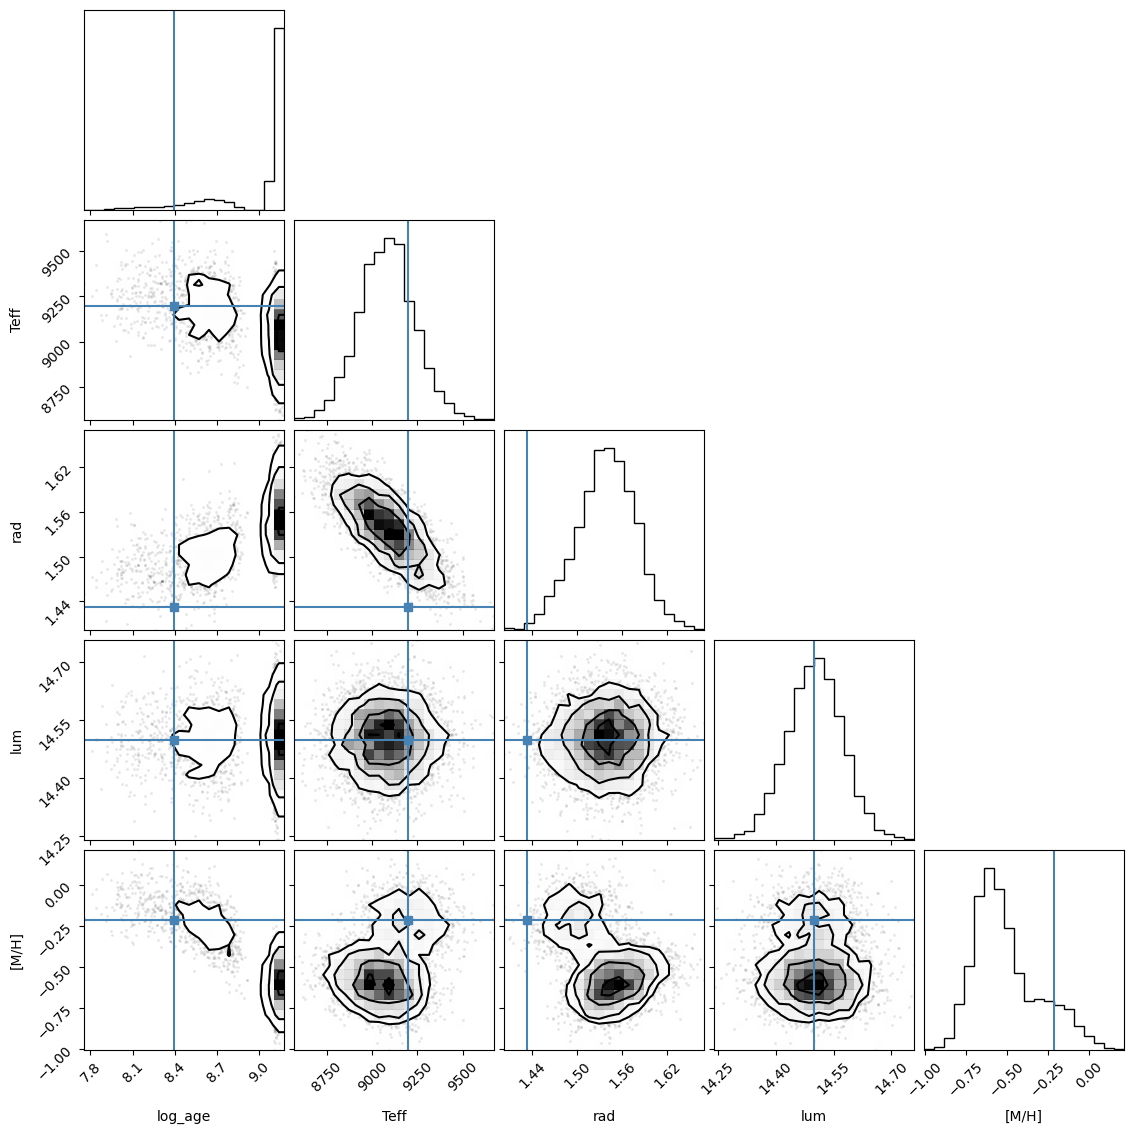

In [32]:
star = 8
var_names = ["log_age", "Teff", "rad", "lum", "[M/H]"]
truths = {k: true_stars[k][0, star] for k in var_names}
fig = corner(data, group="posterior_predictive", var_names=var_names, coords={"star": star}, truths=truths, divergences=True)

In [43]:
rng, key = random.split(rng)
prior_predictive = Predictive(hierarchical_model, num_samples=1000)
prior_samples = prior_predictive(key, num_stars)

In [44]:
coords = {"star": np.arange(num_stars)}
dims = {k: ["star"] for k, v in prior_samples.items() if v.ndim == 2}
hierarchical_data = az.from_numpyro(prior=prior_samples, coords=coords, dims=dims)
hierarchical_data

Inference data with groups:
	> prior

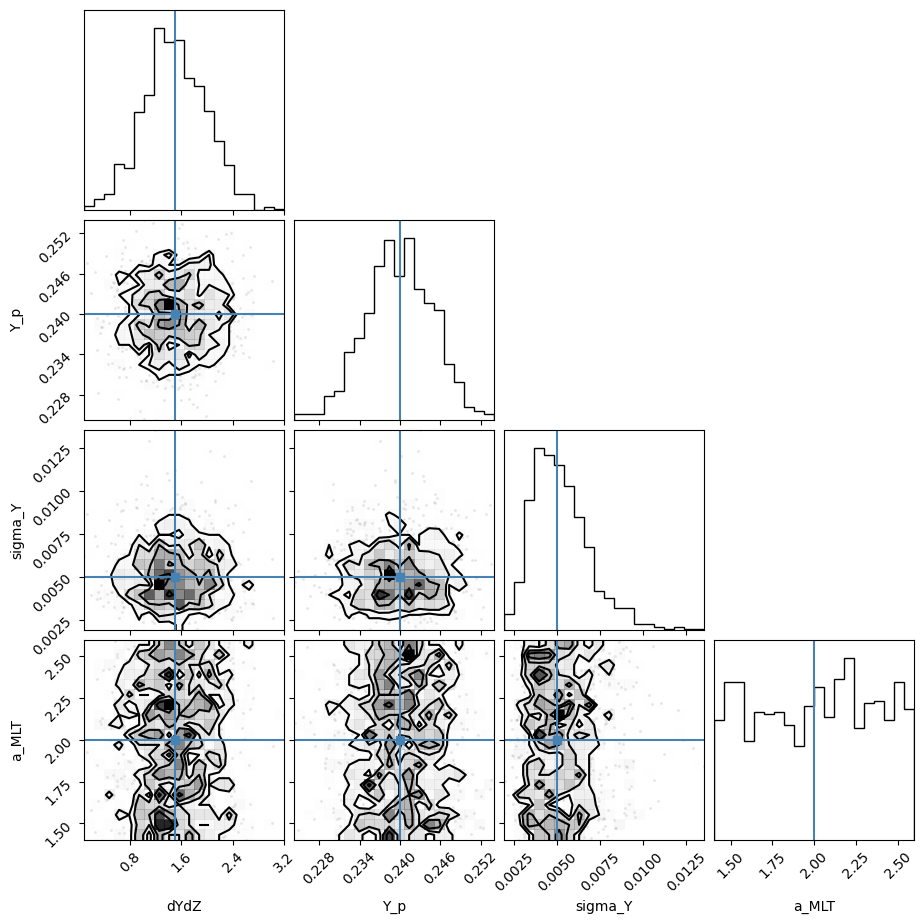

In [45]:
var_names = ["dYdZ", "Y_p", "sigma_Y", "a_MLT"]
fig = corner(hierarchical_data, group="prior", var_names=var_names, truths=true_params)

In [66]:
reparam_config = {
    "Y": LocScaleReparam(0)
}
reparam_model = numpyro.handlers.reparam(hierarchical_model, reparam_config)

In [69]:
dense_mass = False
# dense_mass = [("EEP", "mass")]
nuts = NUTS(
    hierarchical_model, 
    init_strategy=init_to_median, 
    find_heuristic_step_size=True,
    dense_mass=dense_mass,
)
mcmc = MCMC(nuts, num_warmup=2000, num_samples=1000, num_chains=4)

In [70]:
rng, key = random.split(rng)
mcmc.run(key, num_stars, lum=lum, teff=teff, mh=mh)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [71]:
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
         EEP[0]      1.55      0.14      1.57      1.35      1.77     77.15      1.04
         EEP[1]      1.38      0.47      1.64      0.53      1.70      2.04      6.88
         EEP[2]      1.23      0.12      1.24      1.05      1.44    956.35      1.00
         EEP[3]      2.76      0.29      2.85      2.26      3.10      3.12      1.64
         EEP[4]      0.63      0.34      0.60      0.10      1.12     19.05      1.09
         EEP[5]      3.08      0.24      3.18      2.64      3.37      2.37      2.51
         EEP[6]      2.91      0.87      3.32      1.40      3.62      2.01     13.81
         EEP[7]      2.51      0.36      2.59      1.96      3.00      2.79      1.87
         EEP[8]      2.43      0.39      2.50      1.85      3.04      3.15      1.63
         EEP[9]      0.72      0.32      0.74      0.15      1.16    306.62      1.03
Y_decentered[0]     -0.00      1.03     -0.00     -1.

In [72]:
hierarchical_data += az.from_numpyro(mcmc, coords=coords, dims=dims)
hierarchical_data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

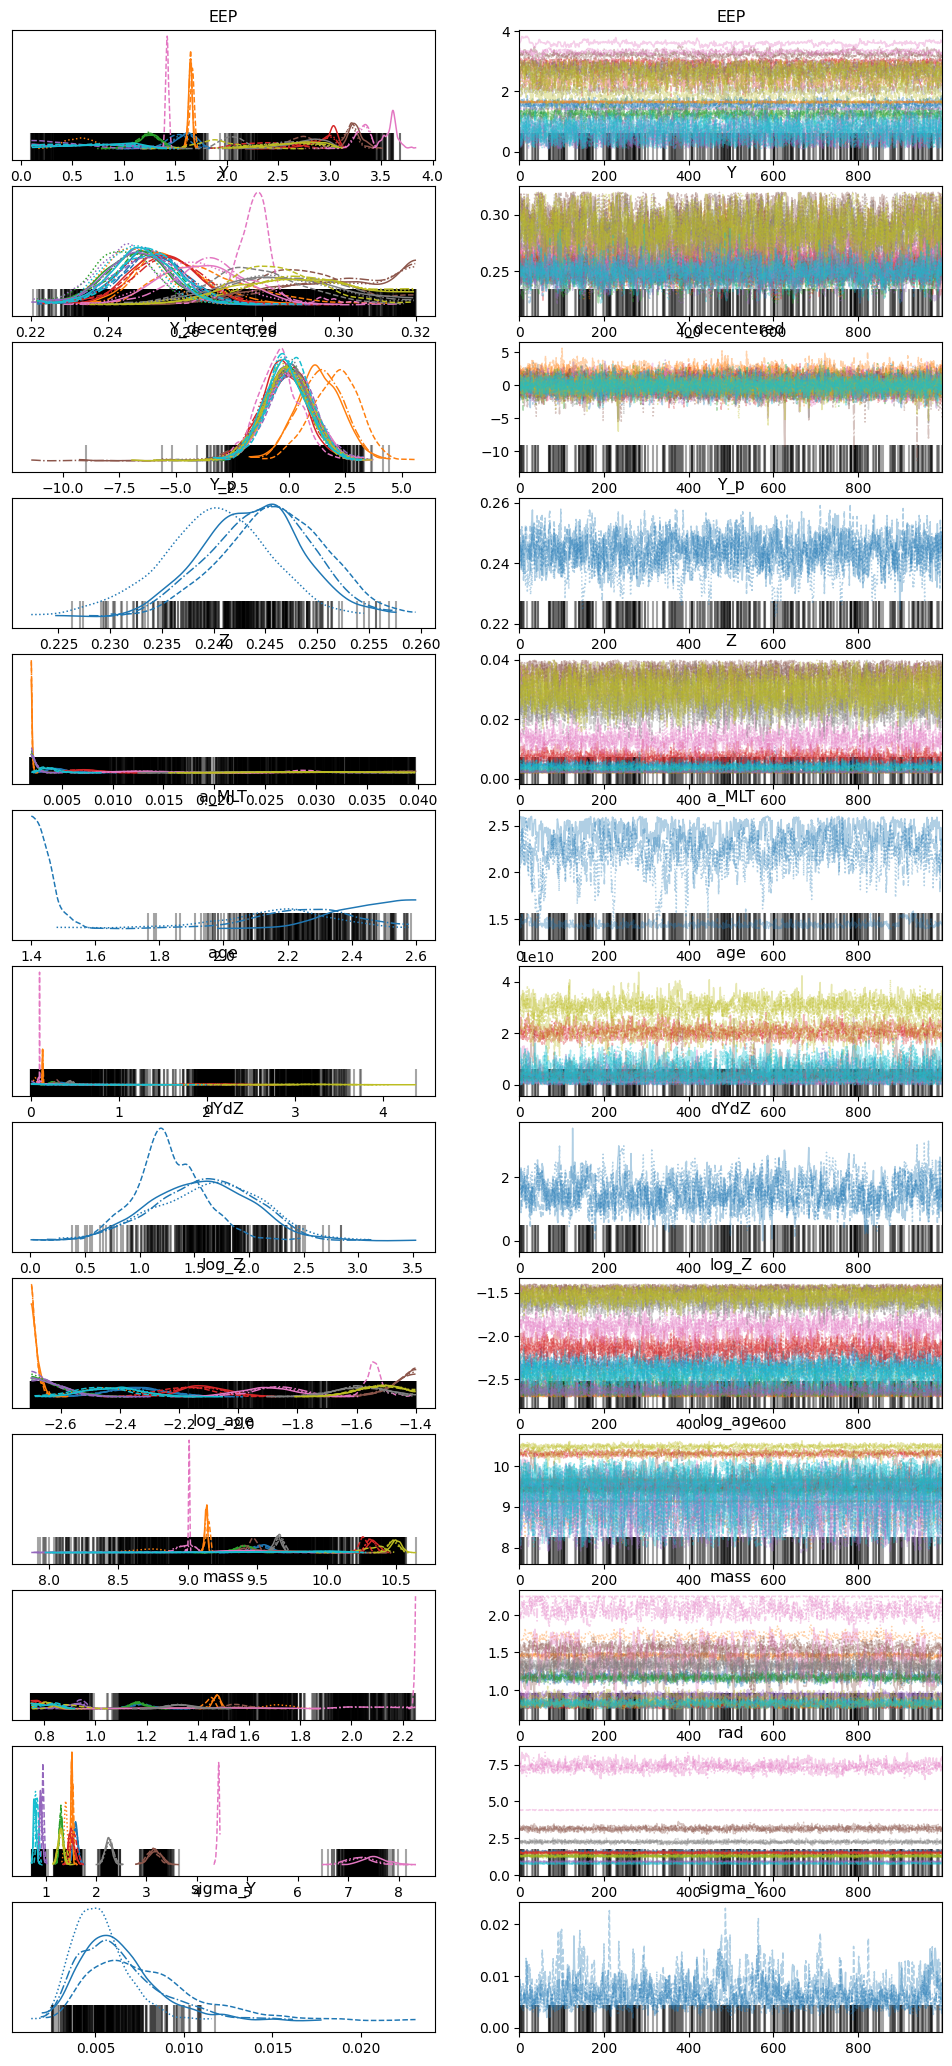

In [73]:
az.plot_trace(hierarchical_data);

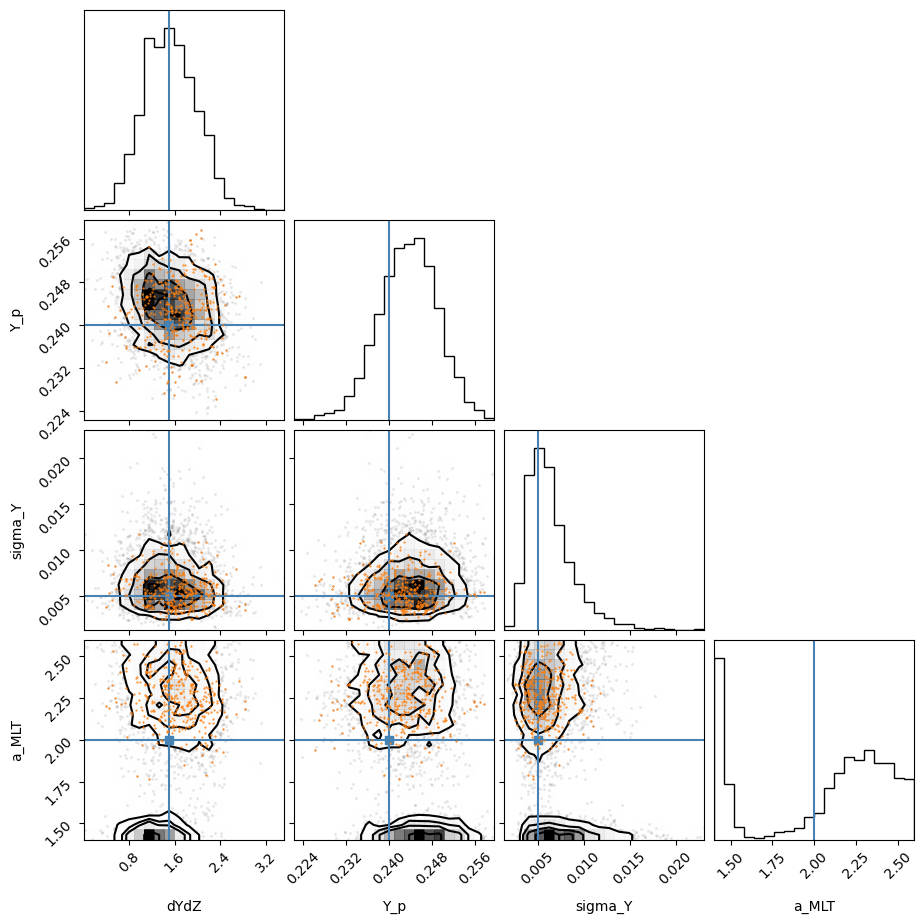

In [74]:
var_names = ["dYdZ", "Y_p", "sigma_Y", "a_MLT"]
fig = corner(hierarchical_data, group="posterior", var_names=var_names, truths=true_params, divergences=True)

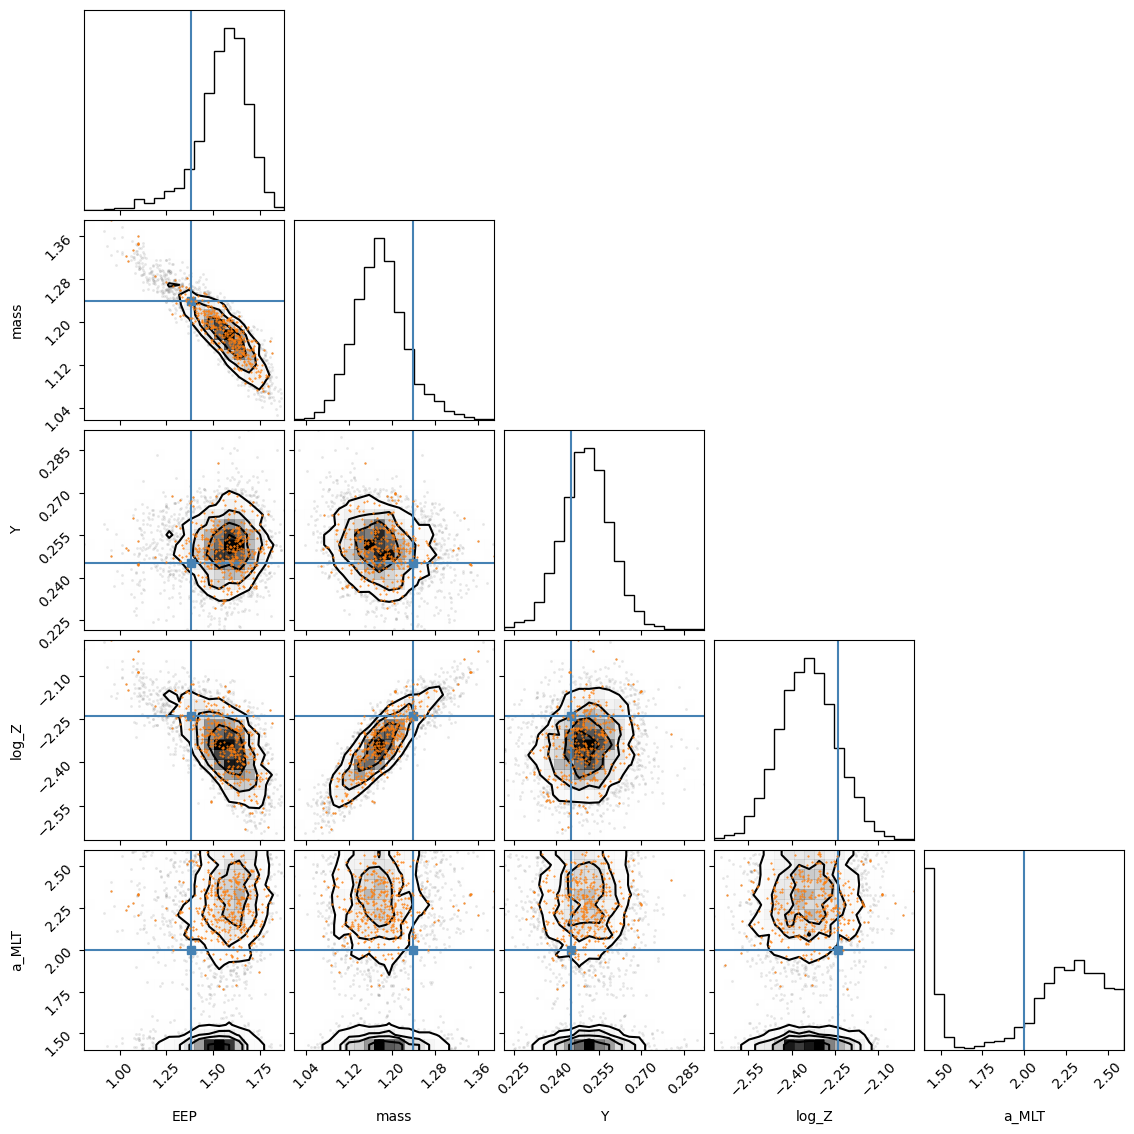

In [75]:
star = 0
var_names = ["EEP", "mass", "Y", "log_Z", "a_MLT"]
truths = {k: true_params[k] if k in true_params else true_stars[k][0, star] for k in var_names}
fig = corner(hierarchical_data, group="posterior", var_names=var_names, coords={"star": star}, truths=truths, divergences=True)

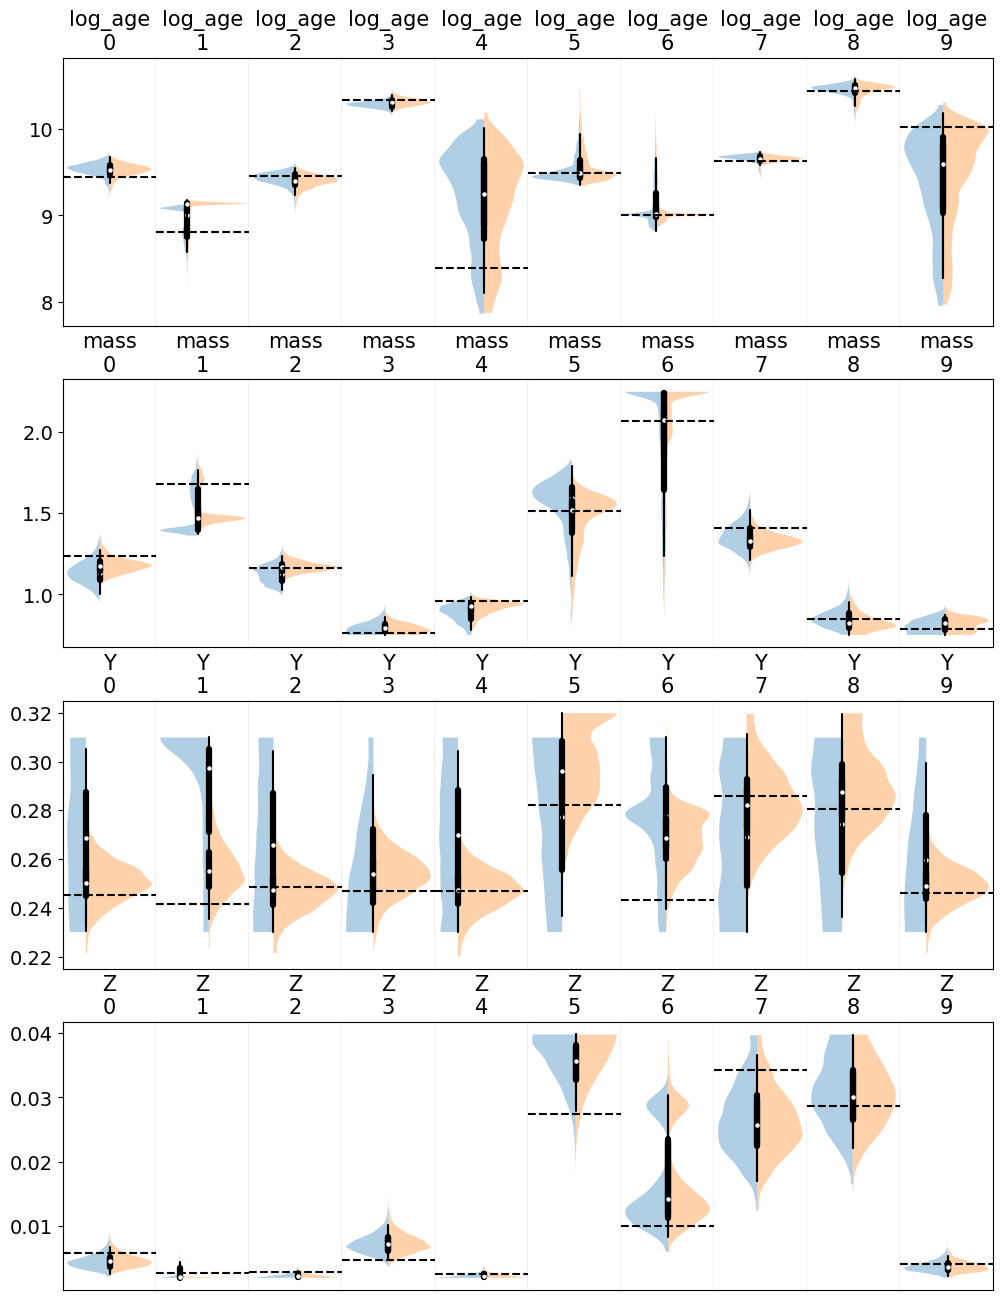

In [76]:
var_names = ["log_age", "mass", "Y", "Z"]
figsize = (12, 4*len(var_names))
grid = (len(var_names), num_stars)
show_prior = False
sharex = False
sharey = "row"
if show_prior:
    axes = az.plot_violin(
        data.prior,
        var_names=var_names,
        side="left",
        figsize=figsize,
        grid=grid,
        sharex=sharex,
        sharey=sharey,
        shade_kwargs=dict(color="gray"),
    )

    axes = az.plot_violin(
        hierarchical_data.prior,
        var_names=var_names,
        side="right",
        ax=axes,
        figsize=figsize,
        grid=grid,
        sharex=sharex,
        sharey=sharey,
        shade_kwargs=dict(color="gray"),
    )
else:
    axes = None

axes = az.plot_violin(
    data,
    var_names=var_names,
    side="left",
    ax=axes,
    figsize=figsize,
    grid=grid,
    sharex=sharex,
    sharey=sharey,
)
axes = az.plot_violin(
    hierarchical_data,
    var_names=var_names,
    side="right",
    ax=axes,
    figsize=figsize,
    grid=grid,
    sharex=sharex,
    sharey=sharey,
)

for i, k in enumerate(var_names):
    for j in range(num_stars):
        axes[i, j].axhline(true_stars[k][0, j], c="k", ls="--")